# Klasifikasi Dataset Fashion Mnist (Model CNN)

Contoh Deloyment untuk Domain Computer Vision (CV) <br>
Orbit Future Academy - AI Mastery - KM Batch 3 <br>
Tim Deployment dan Tim CV<br>
2022

## Modules dan Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
import tensorflow.keras.utils
import ssl
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout,LeakyReLU
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator #gw tambahin (reza)
from tensorflow.keras.callbacks import LearningRateScheduler #gw tambahin (reza)
import os

%matplotlib inline
K.clear_session()

# NOTE : 
# gua males jelasin lagin satu-satu, kalo mo tau lu pake chat GPT aja (reza) 
# atau kalo mau baca setiap comment yang gw tambahin
# Kalo mo ngerubah kasih nama sebelahnya, biar kalo ada yang crash bisa tanya sama yang ngerubah

In [2]:
print(tf.config.list_physical_devices('GPU')) #cek GPU on apa engga +pake GPU yang mana

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Import Data

In [3]:
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [5]:
NUM_CLASSES = 10 #rubah nyesuain dataset yang baru(reza)
fashion_mnist_classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
                         "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

## Exploratory Data Analysis (EDA)

In [6]:
print("Train samples:", x_train.shape, y_train.shape) #disini lo bisa tau shapenya buat ubah bawahnya (reza)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (60000, 28, 28) (60000,)
Test samples: (10000, 28, 28) (10000,)


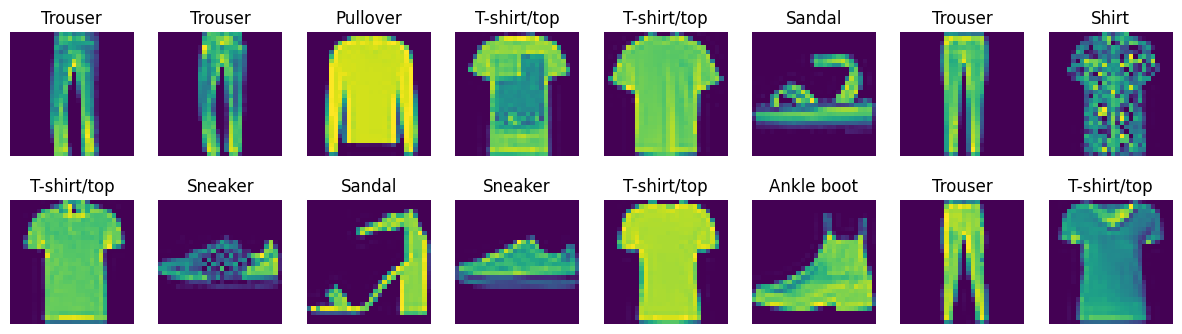

In [7]:
# Menampilkan Gambar pada Dataset Latih
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index]) #dirubah soalnya grayscale 1 channel (reza)
        ax.set_title(fashion_mnist_classes[y_train[random_index]]) #dirubah soalnya grayscale 1 channel (reza)
plt.show()

## Menyiapkan Data

Kita akan melakukan normalisasi data input seperti berikut : $$x_{norm} = \frac{x}{255} - 0.5$$

Kita perlu melakukan konversi label kelas menjadi one-hot encoded vectors. Silahkan gunakan __keras.utils.to_categorical__.

In [8]:
# Normalisasi Input
x_train2 = (x_train / 255) - 0.5
x_test2  = (x_test / 255) - 0.5

# Mengkonversi Label Class menjadi One-Hot Encoded
y_train2 = tensorflow.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test2  = tensorflow.keras.utils.to_categorical(y_test, NUM_CLASSES)

In [9]:
# Data Augmentation
#gua tambahin Data Augmentation biar makin banyak variasi data (reza)
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Reshape input data
# di reshape biar ga error (cari di chat GPT kenapa harus di reshape)(reza)
x_train = x_train.reshape(-1, 28, 28, 1)

# Fit the datagen on the reshaped training data
datagen.fit(x_train)

## Membuat Arsitektur Model CNN 

In [10]:
def make_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), input_shape=(28, 28, 1), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    return model

In [11]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                        

# Train model

In [42]:
INIT_LR    = 5e-3  
BATCH_SIZE = 32
EPOCHS     = 160

model = make_model() 

model.compile(
    loss='categorical_crossentropy',
    optimizer=tensorflow.keras.optimizers.Adamax(learning_rate=INIT_LR),
    metrics=['accuracy']
)
#tinggal dituker kalo mau pake yang 4 var
""" 
def lr_scheduler(epoch):
    lr = INIT_LR
    if epoch < 100:
        return lr
    elif epoch < 150:
        return lr * 0.75
    elif epoch < 200:
        return lr * 0.5
    elif epoch < 250:
        return lr * 0.25
    else:
        return lr * 0.1
"""
    
    def lr_scheduler(epoch):
    lr = INIT_LR
    if epoch > 150:
        lr *= 0.1
    elif epoch > 100:
        lr *= 0.5
    return lr

lr_schedule = LearningRateScheduler(lr_scheduler)

IndentationError: unexpected indent (1912479630.py, line 28)

In [43]:
model.fit(
    x_train2,
    y_train2,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_test2, y_test2),
    shuffle=True,
    verbose=2,
    callbacks=[lr_schedule]
)

Epoch 1/310
1875/1875 - 5s - loss: 0.0844 - accuracy: 0.9724 - val_loss: 0.3384 - val_accuracy: 0.9340 - lr: 0.0050 - 5s/epoch - 3ms/step
Epoch 2/310


KeyboardInterrupt: 

## Prediksi

In [31]:
# Prediksi untuk Data Latih
y_pred_train = model.predict(x_train2)
y_pred_train_classes = np.argmax(y_pred_train, axis=1)
y_pred_train_max_probas = np.max(y_pred_train, axis=1)

1875/1875 [==============================] - 3s 2ms/step


In [32]:
# Prediksi untuk Data Uji
y_pred_test = model.predict(x_test2)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

313/313 [==============================] - 1s 2ms/step


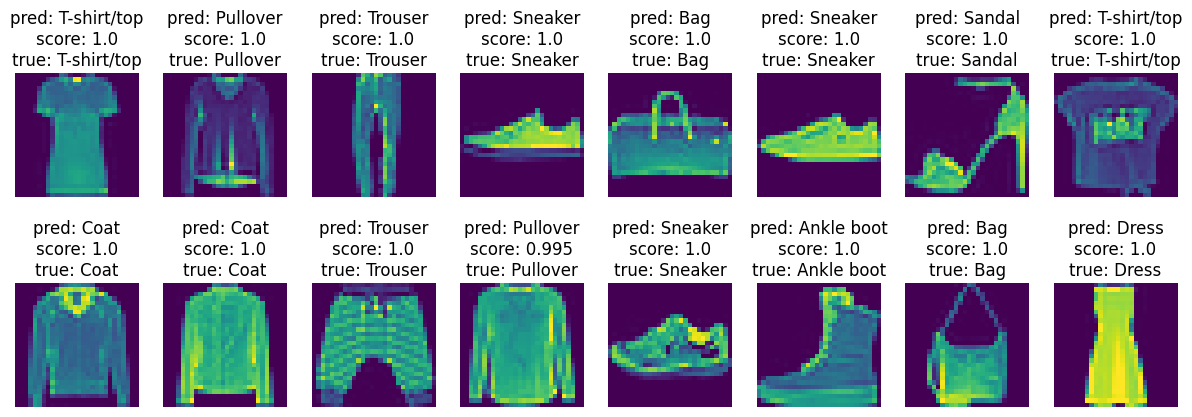

In [35]:
# Menampilkan Hasil Prediksi untuk Data Latih
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        pred_label = fashion_mnist_classes[y_pred_train_classes[random_index]]
        pred_proba = y_pred_train_max_probas[random_index]
        true_label = fashion_mnist_classes[y_train[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

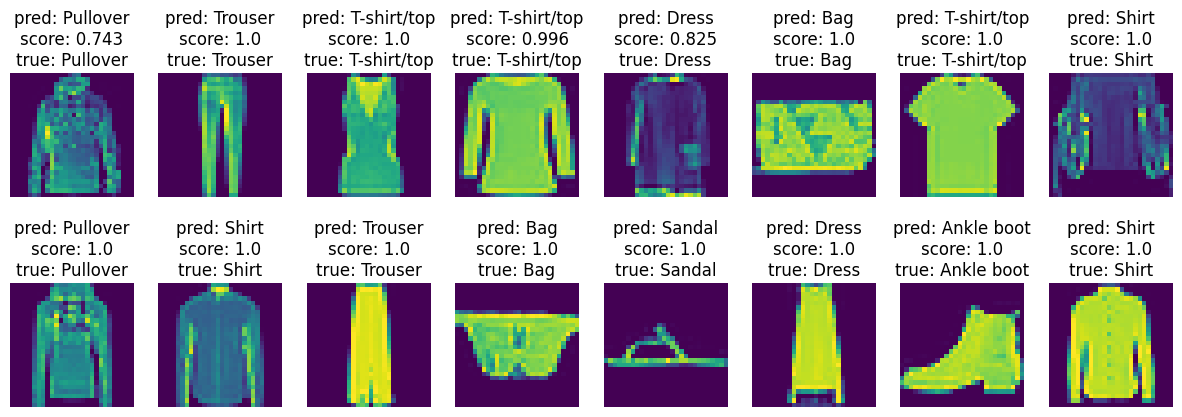

In [36]:
# Menampilkan Hasil Prediksi untuk Data Uji
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = fashion_mnist_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = fashion_mnist_classes[y_test[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

## Evaluate model

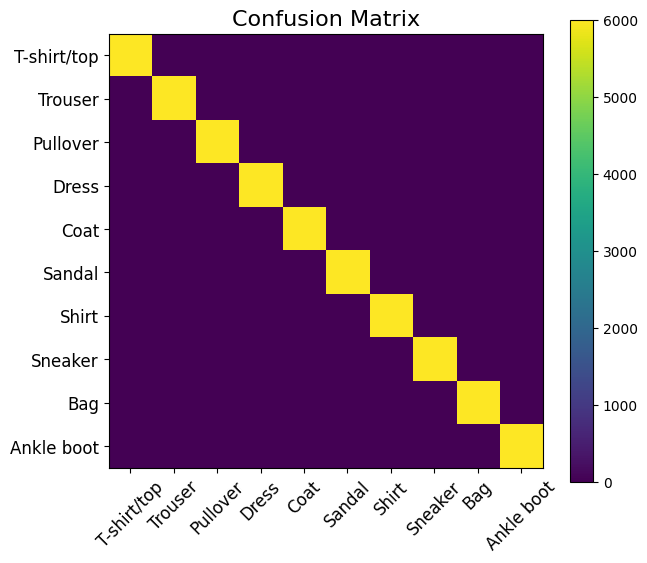

Train Accuracy: 0.9997666666666667


In [37]:
# Confusion Matrix dan Akurasi untuk Data Latih
plt.figure(figsize=(7, 6))
plt.title('Confusion Matrix', fontsize=16)
plt.imshow(confusion_matrix(y_train, y_pred_train_classes))
plt.xticks(np.arange(10), fashion_mnist_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), fashion_mnist_classes, fontsize=12)
plt.colorbar()
plt.show()

print("Train Accuracy:", accuracy_score(y_train, y_pred_train_classes))

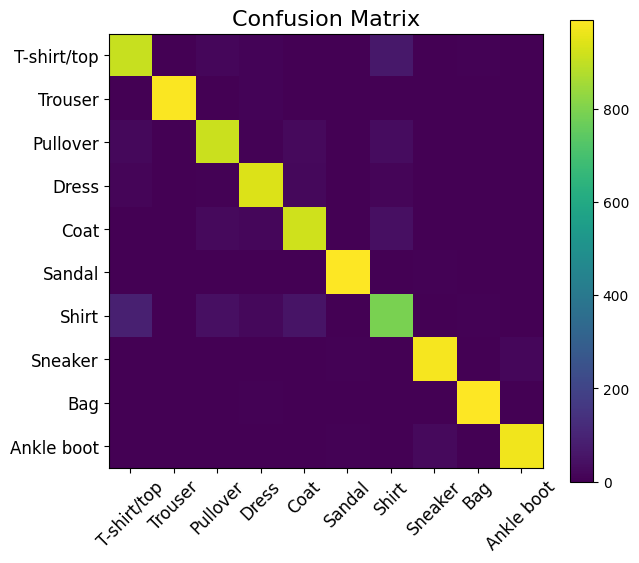

Test Accuracy: 0.9383


In [38]:
# Confusion Matrix dan Akurasi untuk Data Uji
plt.figure(figsize=(7, 6))
plt.title('Confusion Matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test, y_pred_test_classes))
plt.xticks(np.arange(10), fashion_mnist_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), fashion_mnist_classes, fontsize=12)
plt.colorbar()
plt.show()

print("Test Accuracy:", accuracy_score(y_test, y_pred_test_classes))

## Menyimpan Model

In [39]:
model.save_weights("model_fashion_mnist_cnn_tf.h5")

In [ ]:
"""
NOTE:
-> epoch 250 (non scheduler LR) : train=0.99081 test=0.9335 
-> epoch 160 (Scheduler LR (2/)): train=0.99916 test=0.9394
-> epoch 400 (Scheduler LR (4/)): train=0.9998  test=0.9398
-> epoch 310 (Scheduler LR (4/)): train0.99976  test=0.9383
"""